# Analysis of Front-page New York Times Articles (1996-2006)

### Importing Libraries and Loading DF

In [53]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Vectorization
from sklearn.cluster import KMeans # K-Means Clustering

In [54]:
# Load Dataset
df = pd.read_csv("US-Media-NYTimes.csv")

# Inspect the Data
display(df.head())
df.info()

,id,year,majortopic,subtopic,title,summary
0,69,1996,1,100,A Sharp Pullback,stock market slides
1,82,1996,1,100,Market Drop Grabs Notice Of Both Sides,stock market drops
2,196,1996,1,100,Flood of Cash to Mutual Funds Helped to Fuel '...,mutual funds doing well
3,335,1996,1,100,"Stocks Surge Again; Dow Exceeds 5,600",stock market
4,389,1996,1,100,ECONOMIC PULSE: The New York Region; Region's ...,NY economy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31034 entries, 0 to 31033
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31034 non-null  int64 
 1   year        31034 non-null  int64 
 2   majortopic  31034 non-null  int64 
 3   subtopic    31034 non-null  int64 
 4   title       31031 non-null  object
 5   summary     30976 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


### Cleaning the Data

In [ ]:
# Replace Unclear Text Responses with Missing Values
df.replace({"No Response": pd.NA, "?": pd.NA, "": pd.NA}, inplace=True)

# Strip Whitespace from Strings
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Convert Columns to Numeric
df["id"] = pd.to_numeric(df["id"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["majortopic"] = pd.to_numeric(df["majortopic"], errors="coerce")
df["subtopic"] = pd.to_numeric(df["subtopic"], errors="coerce")

# Standardize Text by Converting All to Lowercase
df["title"] = df["title"].str.lower()
df["summary"] = df["summary"].str.lower()

# Combine Text for Analysis
df['text'] = df['title'].fillna("") + " " + df["summary"].fillna("")

# Remove Duplicates and Missing Values After Cleaning
df = df.drop_duplicates()
df = df.dropna()

print("Remaining Missing Values:", df.isna().sum().sum())

Remaining missing values: 0


C:\Users\wwsc2\AppData\Local\Temp\ipykernel_26544\4112288358.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


### Basic Descriptive Analysis

year
1996    2944
1997    2897
1998    2955
1999    2917
2000    2919
2001    2936
2002    3055
2003    2931
2004    2589
2005    2357
2006    2473
Name: id, dtype: int64


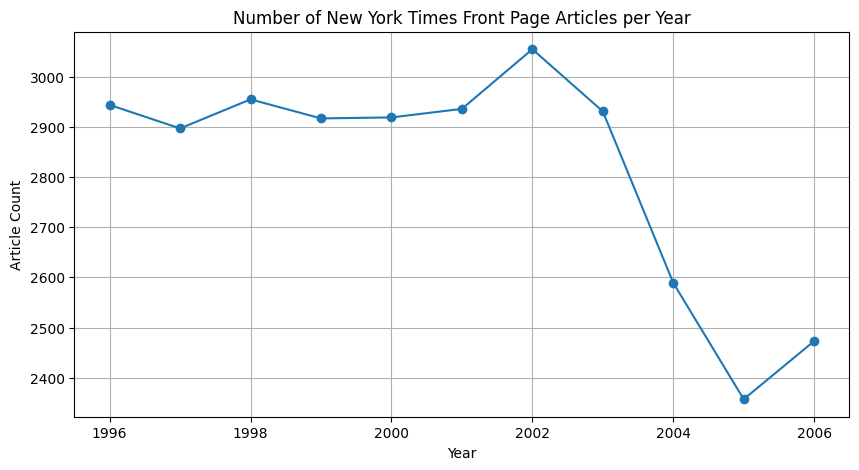

In [56]:
# Article Counts per Year
articles_per_year = df.groupby("year")["id"].count()
print(articles_per_year)

plt.figure(figsize=(10,5))
plt.plot(articles_per_year.index, articles_per_year.values, marker='o')
plt.title("Number of New York Times Front Page Articles per Year")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.grid()
plt.show()

### Standardized Comparison of Election vs Non-Election Years

Standardized Average Article Output:
election_period
Election Year        2931.5
Non-Election Year    2790.0
Name: article_count, dtype: float64


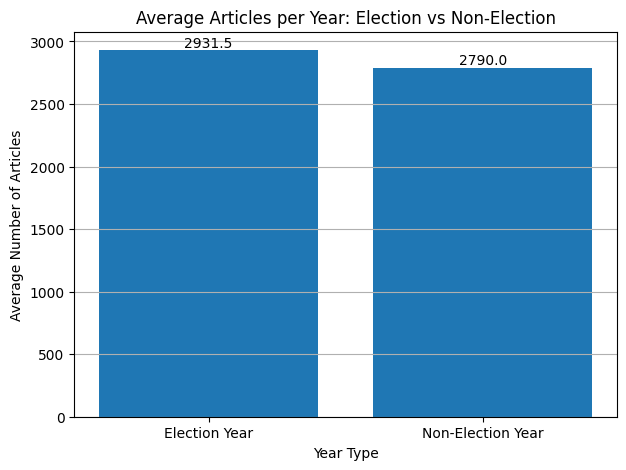

In [57]:
# Create a Dataframe from Yearly Counts
year_counts = pd.DataFrame({
    "year": articles_per_year.index,
    "article_count": articles_per_year.values
})

# Label Each Year as Election or Not
election_years = [1996, 2000]
year_counts["election_period"] = year_counts["year"].apply(
    lambda x: "Election Year" if x in election_years else "Non-Election Year"
)

# Compute Average Articles per Year for Each Category
avg_counts = year_counts.groupby("election_period")["article_count"].mean()

print("Standardized Average Article Output:")
print(avg_counts)

# Bar Plot of Standardized Averages
plt.figure(figsize=(7,5))
bars= plt.bar(avg_counts.index, avg_counts.values)

plt.bar_label(bars, fmt="%.1f") # Add value labels on bars
plt.title("Average Articles per Year: Election vs Non-Election")
plt.ylabel("Average Number of Articles")
plt.xlabel("Year Type")
plt.grid(axis='y')
plt.show()

### Implementing TF-IDF 

In [ ]:
# Purpose: To identify how the relevance of certain keywords has changed over time in New York Times front page articles.
# TF-IDF is a statistical model which evaluates the imporants of natural language terms in a document in relation to a larger collection of documents. It is a combination of two elements, term frequency (TF: how often a word appears in a document) and inverse document frequency (IDF: it reduces the weight of common words throughout multiple documents while increasing the weight for words that are less common/rare). 

# Convert Full Text into TF-IDF Representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['text']) 

# Store Features
features = vectorizer.get_feature_names_out()

# Build df of TF-IDF Values
df_features = pd.DataFrame(X.toarray(), columns = features)
df_features["year"] = df["year"]

# Average TF-IDF Values per Year
yearly_trends = df_features.groupby("year").mean()

### Elbow Method to Determine K for K-Means Clustering

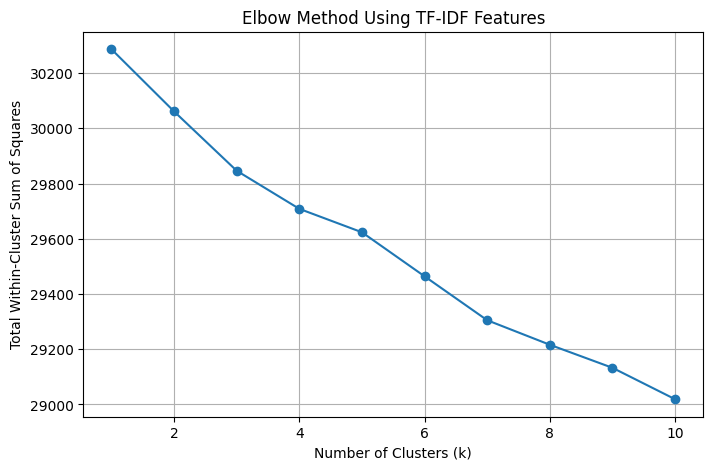

In [59]:
# Elbow Method for Text-Based Clustering (TF-IDF)
wss = []

# Try different values of k (1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=123)
    kmeans.fit(X)              
    wss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wss, marker='o')
plt.title("Elbow Method Using TF-IDF Features")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Total Within-Cluster Sum of Squares")
plt.grid(True)
plt.show()

In [ ]:
# From the elbow plot above I chose optimal k (k=3) by determining the point where there was the largest inflection (elbow)
optimal_k = 4

### K-Means Clustering

In [ ]:
# Topic Clustering Using K-Means
# Purpose: Is to see if articles naturally group by themes
# K Means Clustering is an unsupervised machine learning algorithm that groups data points into k number of clusters based on the similarity of their features. It minimizes the variance within each cluster, while maximizing the variance between different clusters.

kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=123)
df['cluster'] = kmeans.fit_predict(X)

# Show Sample Articles from Each Cluster
for c in df["cluster"].unique():
    print(f"\n Cluster {c} Example Titles")
    print(df[df["cluster"]==c]["title"].head(5))

# Topics seem to be grouped by major themes such as U.S Politics, Local and Regional U.S. News, International War and Security, and Global Diplomacy.


 Cluster 0 Example Titles
0                                     a sharp pullback
1               market drop grabs notice of both sides
2    flood of cash to mutual funds helped to fuel '...
3                stocks surge again; dow exceeds 5,600
5    economy slowed in late 1995 as growth rate dip...
Name: title, dtype: object

 Cluster 1 Example Titles
4     economic pulse: the new york region; region's ...
30    wall st. profits lead a recovery in new york city
45    unromantic economic facts cast pall over niaga...
46    stocks race past new milestone as dow breaks 7...
47                         economic pulse: new england;
Name: title, dtype: object

 Cluster 3 Example Titles
413           newest export out of china: inflation fears
2506    whirlwind of facial surgery by foreigners upse...
2746    new health worry for china as sars hits the hi...
2754           from china sea to u.s. campus, quarantined
4054       despite defeat on china bill, labor is on rise
Name: title, dtype: 

### TF-IDF Word Trend Analysis

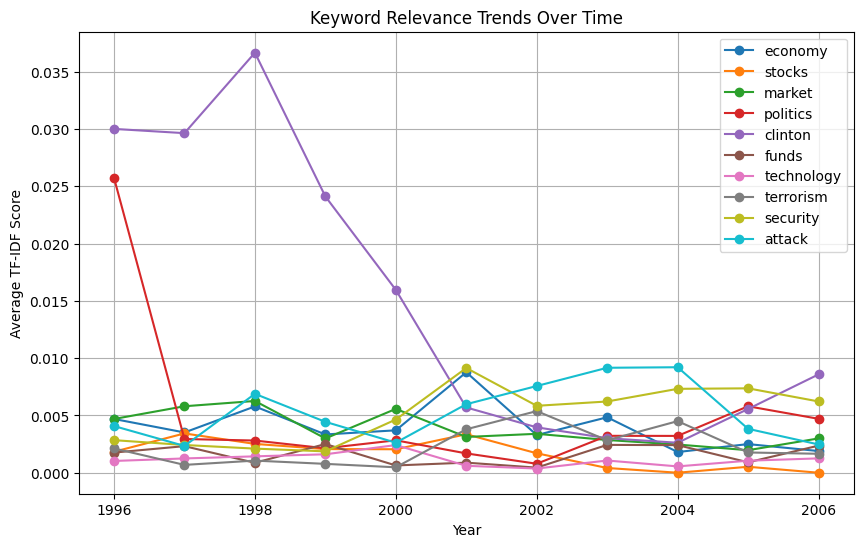

In [62]:
# Choose Relevant Keywords
keywords = ["economy", "stocks", "market", "politics", "clinton", "funds", "technology", "terrorism", "security", "attack"]

# Plot Keyword Trends Over Time
plt.figure(figsize=(10,6))

for word in keywords:
    if word in yearly_trends:
        plt.plot(yearly_trends.index, yearly_trends[word], marker="o", label=word)

plt.title("Keyword Relevance Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.legend()
plt.grid()
plt.show()

### Analysis of Keyword Spike After 9/11 

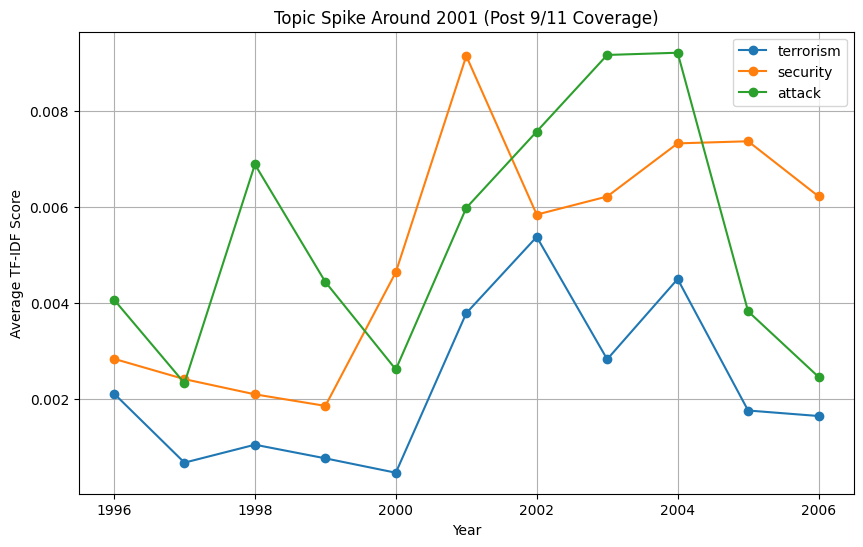

In [ ]:
# Compare Keyword TF-IDF Before vs After 2001
before_2001 = yearly_trends.loc[yearly_trends.index < 2001]
after_2001 = yearly_trends.loc[yearly_trends.index == 2001]

# Focused Plot for Keywords Significant to 9/11
focus_words = ["terrorism", "security", "attack"]

# Loop Through Keywords and Plot Trends
plt.figure(figsize=(10,6))
for word in focus_words:
    if word in yearly_trends:
        plt.plot(yearly_trends.index, yearly_trends[word], marker="o", label=word)

plt.title("Topic Spike Around 2001 (Post 9/11 Coverage)")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.legend()
plt.grid()
plt.show()

### Analysis of Keyword Spike Around the  Tech Bubble/Dot-Com Crash (2000) 

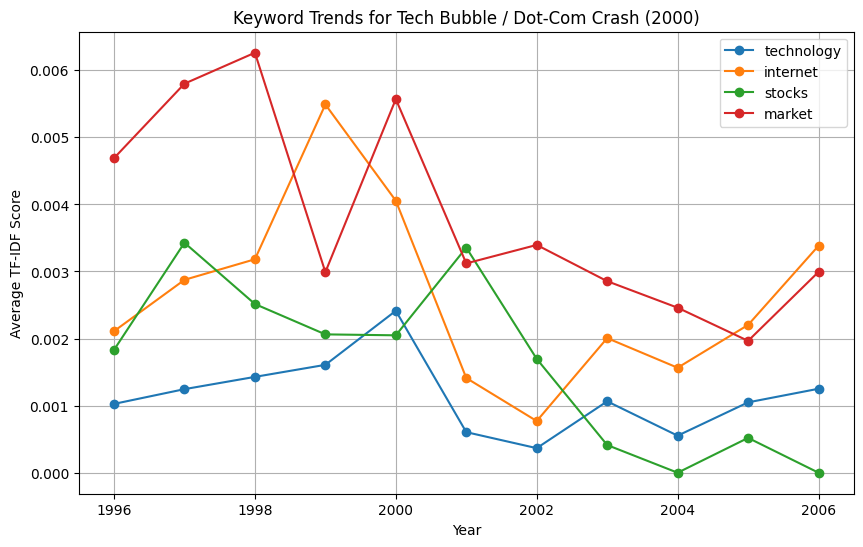

In [64]:
# Keywords Connected to the Dot-Com Boom and Crash
tech_bubble_words = ["technology", "internet", "stocks", "market", "bubble", "tech", "startup"]

# Loop Through Keywords and Plot Trends
plt.figure(figsize=(10,6))

for word in tech_bubble_words:
    if word in yearly_trends:
        plt.plot(yearly_trends.index, yearly_trends[word], marker="o", label=word)

plt.title("Keyword Trends for Tech Bubble / Dot-Com Crash (2000)")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.legend()
plt.grid()
plt.show()

### Analysis of Keyword Spike Around Clinton's Impeachment (1998) 

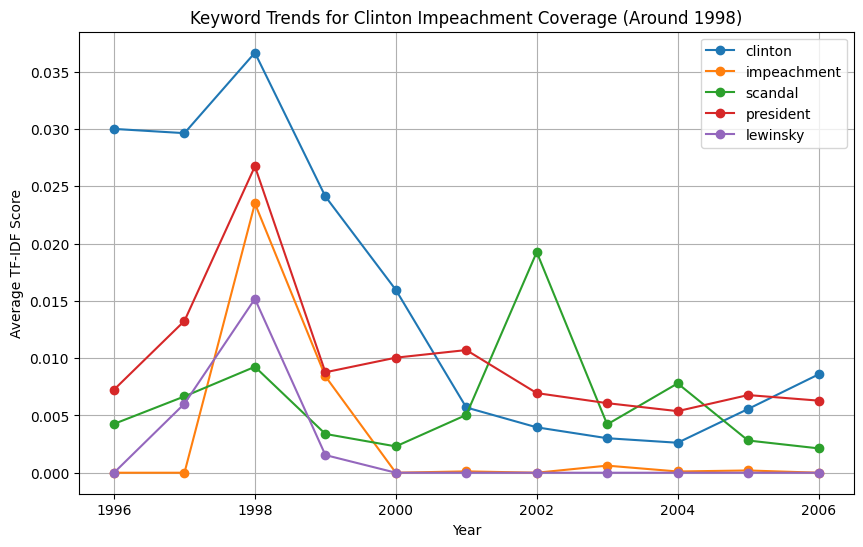

In [ ]:
# Keywords Connected to Impeachment Events
clinton_words = ["clinton", "impeachment", "scandal", "president", "lewinsky"]

# Loop Through Keywords and Plot Trends
plt.figure(figsize=(10,6))

for word in clinton_words:
    if word in yearly_trends:
        plt.plot(yearly_trends.index, yearly_trends[word], marker="o", label=word)

plt.title("Keyword Trends for Clinton Impeachment Coverage (Around 1998)")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.legend()
plt.grid()
plt.show()


### Summary Outputs for TF-IDF

In [66]:
print("Top 10 strongest TF-IDF words overall:")
print(yearly_trends.mean().sort_values(ascending=False).head(10))

Top 10 strongest TF-IDF words overall:
new          0.025788
iraq         0.019105
bush         0.017771
clinton      0.015071
war          0.011322
campaign     0.010880
york         0.010148
president    0.009837
election     0.009092
china        0.008991
dtype: float64


## Citation:
Boydstun, Amber. 2013. Making the News: Politics, the Media, and Agenda Setting. The University of Chicago Press. 

GeeksforGeeks. (2021, January 20). Understanding TFIDF (Term FrequencyInverse Document Frequency). GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/